# NLP_GoingDeeper | E01. Sentencepiece

---

**[Introduce]**

- 문장을 만드는 것은 퍼즐 맞추는 것과도 비슷한 것 같습니다.
- 조각들이 제각기 다른 모양을 가지고 있고, 맞는 위치에 있더라도 그림이 다를 수 있습니다. 모양과 그림이 맞아야 비로소 작품이 완성되는 것은, 마치 문맥과 문법을 고려하는 것과 닮았습니다. 
- 그러나 우리의 문장 퍼즐은 단 하나의 작품을 목표로 하지는 않습니다. 올바르게 맞춰진 퍼즐 위의 그림이 잘 어울린다면, 그 자체로 하나의 작품인 것입니다. 

- 오늘은 **문장을 조각내는 방법(토큰화, tokenize)**을 배워보겠습니다. 
- 어떤 문장을 일정한 기준을 갖는 단어로 쪼개는 것은 곧 퍼즐 조각을 나누는 것과 같습니다. 
- 지나치게 잘게 쪼게면 넓은 그림을 담을 수 없어 다시 맞추기 어려울 것이고, 너무 크게 쪼개면 퍼즐이 너무 쉬워질 것입니다. 
- 문장 데이터를 직접 토큰화하며 어떤 방법이 가장 적합한 단어 조각을 만들어내는지 실습해봅시다. 

# 0. 준비
- KoNLPy, 그 중에서 가장 성능이 우수한 MeCab클래스를 활용해 실습해봅니다. 

```python
#- 우분투 환경에서 설치하기 

! sudo apt-get install g++ openjdk-8-jdk
! bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
! pip install konlpy

#- 맥 OS에서 설치하기

! python3 -m pip install --upgrade pip
! python3 -m pip install konlpy        # Python 3.x
! bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

```
- 참고 : [설치하기 - KoNLPy 0.5.2 documentation](https://konlpy.org/ko/latest/install/)

In [1]:
#- Mecab 불러오기

from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어도밥먹는걸잊을순없죠!'))

['자연어', '처리', '가', '너무', '재밌', '어도', '밥', '먹', '는', '걸', '잊', '을', '순', '없', '죠', '!']


In [2]:
#- 라이브러리 불러오기

import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

# 1. 데이터 로드 및 분석
- 데이터를 다운로드 하고 분석해봅니다.
- 분석 결과에 따라 학습에 사용할 적절한 데이터를 추출하겠습니다.(데이터 정제) 
- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1) 는 한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터입니다. 
- 우리가 사용할 korean-english-park.train.ko 는 한국어-영어 병렬을 이루는 말뭉치 중 한국어 부분으로, 전체 병렬 말뭉치는 후에 번역기를 만들며 사용할 예정입니다. 
- 명시되어있는 license [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/)는 Attribution, ShareAlike terms를 조건으로 share, adapt 권한을 제공합니다.


---


- 리눅스 기본 명령어 
    - [wget](http://www.incodom.kr/Linux/%EA%B8%B0%EB%B3%B8%EB%AA%85%EB%A0%B9%EC%96%B4/wget) : 'Web Get'의 약어로 웹 상의 파일을 다운로드 받을 때 사용하는 명령어로 wget은 비 상호작용 네트워크 다운로더입니다. 즉 네트워크 상에서 데이터를 다운로드하는 기능을 수행합니다. HTTP, HTTPS, FTP 프로토콜을 지원하며, HTTP proxy에서 데이터를 가져올 수도 있습니다. 
    - mkdir -p : mkdir 명령어는 make directory의 약자로써 디렉토리를 생성할 때 사용하는 명령어입니다. -p 는 --parents의 약자로, 상위 경로도 함께 생성한다는 의미입니다. 
    - tar -xzvf : tar은 여러 개의 파일은 하나의 파일로 묶거나 풀 때 사용하는 명령으로, 테이프 아카이버(Tape ARchiver)의 앞글자들을 딴 것입니다. -xzvf 옵션은 해당 경로에 xxx.tar.gz 파일의 압축을 해제하도록 합니다. 
    ```
        x : 압축을 해제
        c : 파일을 묶음
        v : 압축 / 해제 과정을 화면에 표시
        z : gunzip을 사용
        f : 파일 이름 지정
        p : 권한(permission)을 원본과 동일하게 유지
    ```
- 참고 : [how to wget a github file](https://unix.stackexchange.com/questions/228412/how-to-wget-a-github-file/387912)


```python 
! wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
! mkdir -p ~/aiffel/sp_tokenizer/data
! mv korean-english-park.train.tar.gz ~/aiffel/sp_tokenizer/data
! cd ~/aiffel/sp_tokenizer/data
! tar -xzvf korean-english-park.train.tar.gz
```

#### 코드 살펴보기

- for sen in raw[0:100][::20]: print(">>",sen) 
    - **raw**는 korean-english-park.train.ko 를 줄바꿈단위로 읽어온 데이터를 저장한 **원문 리스트**입니다. 
    - raw[0:100][::20] 는 0~100번째 까지 리스트 요소 중에서 20 간격으로 데이터를 반환합니다. 따라서 **sen**은 0, 20, 40, 60, 80번째 데이터(**문장**)가 순차적으로 할당되게 됩니다.      


In [3]:
import os 
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r")as f:
    raw = f.read().splitlines()

#print(type(raw))
print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>",sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [4]:
def sen_distribution(raw):
    min_len = 999
    max_len = 0 
    sum_len = 0

    for sen in raw:
        length = len(sen) #- length : 문장(sen)의 길이
        if min_len > length : min_len = length 
        if max_len < length : max_len = length 
        sum_len += length 

    print("문장의 최단 길이:", min_len)
    print("문장의 최장 길이:", max_len)
    print("문장의 평균 길이:", sum_len//len(raw))

    sentence_length = np.zeros((max_len), dtype=np.int)

    for sen in raw:
        sentence_length[len(sen)-1] += 1

    fig, ax = plt.subplots(1,2, figsize = (10,6))

    #- 박스플롯
    ax[0].boxplot(sentence_length)
    ax[0].set_title('Sentence Length')

    #- 막대그래프
    ax[1].bar(range(max_len), sentence_length, width = 1.0)
    ax[1].set_title("Sentence Length Distribution")

    plt.tight_layout()
    plt.show()
    
    return sentence_length

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


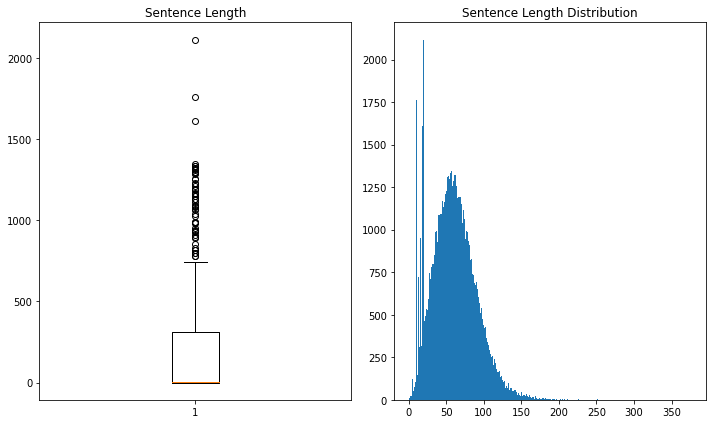

In [5]:
sentence_length = sen_distribution(raw)

- 문장은 94123개가 포함되어 있습니다. 
- 문장의 최단 길이는 1, 최장 길이는 377 로 차이가 큰 편입니다. 
    1. 길이가 1인 문장은 어떤 모습인지 확인합니다.
    2. 길이 약 10-25에 치솟는 임의의 구간의 문장은 어떤 모습인지 확인합니다. 
        - 박스플롯에서 돋보이는, 문장개수가 1500개 이상인 문장길이를 확인합니다. 
    3. 문장길이분포에서 어떤 부분을 학습에 사용해야 적절할까요?

### 1. 길이가 1인 문장은 어떤 모습인지 확인합니다.
- 확인 결과 길이가 1인 문장은 문장부호였습니다. (노이즈)

In [6]:
def check_sentence_with_length(raw,length):
    '''
    raw(원문 리스트)의 요소들을 순차적으로 sen(문장)에 할당하여, 
    입력인자로 넣은 length 와 길이가 같을 경우 출력한다.
    (선택) 길이가 같은 문장 하나만 출력하거나, 최대 100개를 출력한다.
    '''
    
    cnt = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            # return #- 길이가 같은 문장 하나만 출력하고 함수에서 빠져나온다.
            cnt +=1
            if cnt > 100: return

check_sentence_with_length(raw,1)

’


### 2. 문장길이분포에서 치솟는 임의의 구간의 문장은 어떤 모습인지 확인합니다. 
- 문장의 수가 1500을 초과하는 문장을 확인해본 결과, 중복된 문장이 다수 보였습니다. 
- python의 기본 자료형 set(집합)을 활용하여 중복된 요소를 제거합니다. 단, set을 사용할 경우, list의 순서가 뒤섞일 수 있으므로, 번역 데이터와 같이 쌍을 이뤄야 하는 경우엔 주의해서 활용해야 합니다.

In [7]:
for idx, _sum in enumerate(sentence_length):
    #- 문장의 수가 1500을 초과하는 문장길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [8]:
check_sentence_with_length(raw, 11)
# check_sentence_with_length(raw, 19)
# check_sentence_with_length(raw, 21)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

< BEFORE : RAW >

Data Size: 94123
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


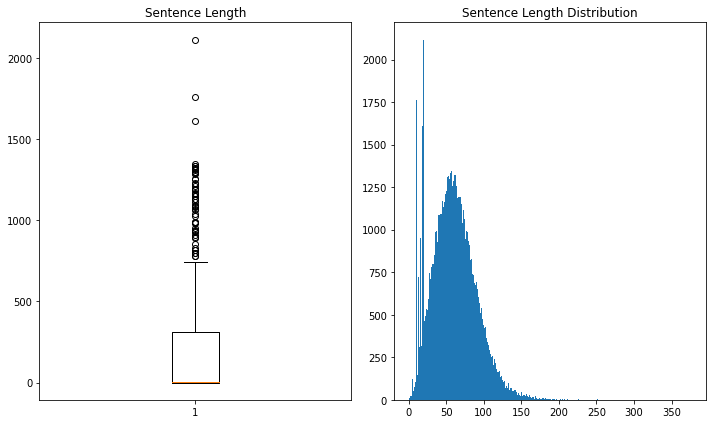



< AFTER : CLEANED >

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


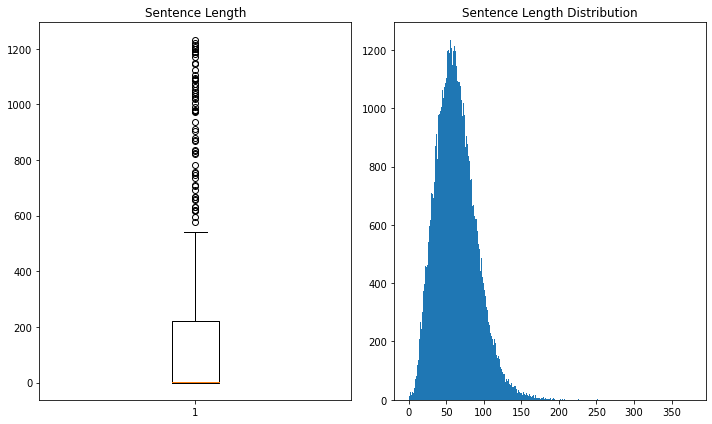

array([   1,   12,   14,   27,   18,   26,   33,   24,   42,   72,   67,
         82,  118,  137,  160,  207,  267,  242,  304,  302,  372,  398,
        427,  459,  456,  464,  515,  541,  596,  616,  711,  655,  705,
        691,  746,  783,  872,  911,  827,  938,  978,  980,  991, 1022,
       1006, 1064, 1036, 1046, 1074, 1088, 1104, 1181, 1198, 1199, 1190,
       1124, 1233, 1207, 1150, 1187, 1198, 1214, 1198, 1219, 1144, 1094,
       1090, 1170, 1089, 1075, 1030, 1051,  972, 1019,  978,  978,  868,
        905,  878,  834,  837,  820,  755,  734,  756,  666,  668,  661,
        630,  619,  620,  633,  578,  535,  516,  481,  443,  487,  422,
        396,  399,  375,  356,  345,  318,  308,  267,  236,  256,  230,
        220,  217,  209,  187,  210,  178,  195,  155,  145,  152,  149,
        139,  111,  134,  105,   95,   89,  108,   88,   62,   71,   69,
         63,   72,   53,   53,   51,   59,   45,   49,   44,   47,   47,
         43,   36,   24,   32,   26,   26,   23,   

In [9]:
cleaned_corpus = list(set(raw)) #- set을 사용해서 중복을 제거합니다.

print("< BEFORE : RAW >\n\nData Size:", len(raw))
sen_distribution(raw)

print("\n\n< AFTER : CLEANED >\n\nData Size:", len(cleaned_corpus))
sen_distribution(cleaned_corpus)

### 3. 문장길이분포에서 어떤 부분을 학습에 사용해야 적절할까요?
- '모든 데이터를 다 사용할 것인가?' 
- 이후 미니 배치를 만들 것을 생각하면, 모든 데이터를 다 사용하는 것은 연산 측면에서 비효율적입니다. 미니 배치 특성 상 각 데이터의 크기가 모두 동일해야 하기 때문에, 가장 긴 데이터를 기준으로 Padding 처리를 해야 합니다. 
- 위 데이터에서 만약 길이가 100인 문장까지만 사용한다면, [ (77591 - 길이 100 초과 문장 수) x 100 ] 의 형태를 갖겠지만, 모두 사용할 경우 [ 77591 x 377] 으로 전자의 경우보다 최소 3.7배 큰 메모리를 차지합니다. 학습시간도 그만큼 더 오래 걸리게 됩니다. 
- 길이별로 정렬하여 미니 배치를 구성해 Padding을 최소화하는 방법도 있지만, 이는 데이터를 섞는데 편향성이 생길 수 있으므로 지양해야 합니다. 
- 여기서는 길이 150 이상의 데이터를 제거하고 사용하도록 하겠습니다.
- 앞서 확인했던 것처럼 너무 짧은 데이터는 오히려 노이즈로 작용할 수 있기에 길이가 10 미만인 데이터도 제거하도록 하겠습니다. 

In [10]:
def threshold_len(min_len, max_len, nested_list): #- length = len(sen)
    '''
    문장의 최대&최소 길이조건을 만족하는
    샘플의 전체샘플에 대한 비율을 출력합니다.
    '''
    cnt = 0
    for sen in nested_list:
        if (len(sen) <= max_len and len(sen) >= min_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이상이면서 %s 이하인 샘플의 비율 : %s'%(min_len, max_len, round(cnt / len(nested_list), 4)))

min_len = 10; max_len = 150
threshold_len(min_len, max_len, cleaned_corpus)

전체 샘플 중 길이가 10 이상이면서 150 이하인 샘플의 비율 : 0.9915


문장의 최단 길이: 10
문장의 최장 길이: 149
문장의 평균 길이: 64


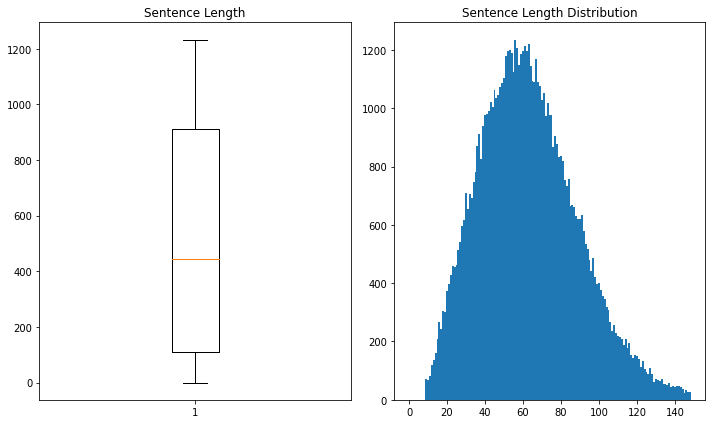

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,   72,   67,
         82,  118,  137,  160,  207,  267,  242,  304,  302,  372,  398,
        427,  459,  456,  464,  515,  541,  596,  616,  711,  655,  705,
        691,  746,  783,  872,  911,  827,  938,  978,  980,  991, 1022,
       1006, 1064, 1036, 1046, 1074, 1088, 1104, 1181, 1198, 1199, 1190,
       1124, 1233, 1207, 1150, 1187, 1198, 1214, 1198, 1219, 1144, 1094,
       1090, 1170, 1089, 1075, 1030, 1051,  972, 1019,  978,  978,  868,
        905,  878,  834,  837,  820,  755,  734,  756,  666,  668,  661,
        630,  619,  620,  633,  578,  535,  516,  481,  443,  487,  422,
        396,  399,  375,  356,  345,  318,  308,  267,  236,  256,  230,
        220,  217,  209,  187,  210,  178,  195,  155,  145,  152,  149,
        139,  111,  134,  105,   95,   89,  108,   88,   62,   71,   69,
         63,   72,   53,   53,   51,   59,   45,   49,   44,   47,   47,
         43,   36,   24,   32,   26,   26])

In [11]:
#- 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]
sen_distribution(filtered_corpus)

# 3. 토큰화 

1. 정제된 데이터를 공백 기반으로 토큰화하여 list에 저장합니다.
2. tokenize() 함수를 사용해 단어 사전과 Tensor 데이터를 얻습니다.(Encoding)
3. 단어사전의 크기를 확인해봅니다.

#### Encoding (Sentence -> Tensor) 
- [tf.keras.preprocessing.text.Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) : (class) Text tokenization utility class. 사전에 있는 단어의 순서에 맞게 단어를 turning 하면서 text corpus를 vectorize 해주는 class 입니다. arguments 중 filters 는 texts에서 걸러낼 string을 입력으로 합니다. 
    - fit_on_texts : (method) Updates internal vocabulary based on a list of texts.
 
    - texts_to_sequences : (method) Transforms each text in texts to a sequence of integers
    
    - index_word : (attribute) fit_on_text 함수에서 업데이트 된 vocab dictionary. {index:word} 형태입니다.

    - word_index : (attribute) fit_on_text 함수에서 업데이트 된 vocab dictionary. {word : index} 형태입니다.
    
    
- [tf.keras.preprocessing.sequence.pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) : Pads sequences to the same length.


#### Decoding(Tensor -> Sentence)

    - tokenizer.sequences_to_texts() : Transforms each sequence into a list of text. returns a list of texts (strings
    - tokenizer.index_word 
    

### 1. 공백 기반 토큰화 
- 공백 기반 토큰화 및 keras의 Tokenizr를 활용하여 Encoding을 진행합니다.

In [12]:
#- 정제된 데이터를 공백 기반으로 토큰화하여 저장합니다.
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [13]:
def tokenize(corpus): #- corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus) #- 단어사전을 업데이트합니다.
    
    tensor = tokenizer.texts_to_sequences(corpus)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

In [14]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 237435


In [15]:
print(type(split_tensor))
print(split_tensor.shape)
split_tensor

<class 'numpy.ndarray'>
(76908, 40)


array([[  3346,  38516,  13839, ...,      0,      0,      0],
       [ 83716,    375,   2468, ...,      0,      0,      0],
       [ 19020,  83717,    240, ...,      0,      0,      0],
       ...,
       [ 76414, 237430,     84, ...,      0,      0,      0],
       [  3883,     13,  80112, ...,      0,      0,      0],
       [    23,  56312,    472, ...,      0,      0,      0]], dtype=int32)

In [16]:
print(type(split_tokenizer))
split_tokenizer

<class 'keras_preprocessing.text.Tokenizer'>


In [17]:
#- 생성된 단어 사전 확인

for idx, word in enumerate(split_tokenizer.word_index): #- dict 형태의 attribute은 key 값(word)을 반환함
    print(idx, ':', word)

    if idx > 10 :break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


- 동사로 이뤄진 단어를 살펴보면, 공백 기반 토큰화의 문제점을 확인할 수 있습니다. 3번 단어인 밝혔다. 는 밝히다, 밝다 등과 유사한 의미를 지니고 있음에도 전혀 다른 단어로 분류될 것입니다.
- 이 때문에 공백 기반 토큰화는 **불필요하게 큰 단어 사전을 가지게 되며, 이는 연산량 증가**로 이어집니다.
- 만일 밝+혔다 라고 토큰화한다면, 밝+히다, 밝+다 같은 구절에서 공통된 어절인 '밝'은 하나로 묶어 학습 중에 의미를 파악하기가 수월할 것입니다. 동시에 단어 사전도 효율적으로 축소되겠죠?
- 이를 위해 **형태소 분석기**가 존재합니다.

### 2. 형태소 기반 토큰화
- 한국어 형태소 분석기는 대표적으로 Khaiii와 KoNLPy가 사용됩니다. 
- 이번에는 KoNLPy, 그 중에서도 가장 성능이 준수한 MeCab 클래스를 활용해 실습해봅니다.
- 형태소를 기반으로 토큰화 하고, keras의 Tokenier를 활용하여 Encoding을 진행합니다. 
- 이후 Decoding을 진행합니다. 

In [18]:
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [19]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 52279


In [20]:
#- 생성된 단어 사전 확인

for idx, word in enumerate(mecab_tokenizer.word_index): #- dict 형태의 attribute은 key 값(word)을 반환함
    print(idx, ':', word)

    if idx > 10 :break

0 : .
1 : 다
2 : 이
3 : 는
4 : 을
5 : 의
6 : 에
7 : 은
8 : 를
9 : 하
10 : 했
11 : 고


In [21]:
print(type(mecab_tensor))
print(mecab_tensor.shape)
mecab_tensor[100]

<class 'numpy.ndarray'>
(76908, 85)


array([   53,    15,  7513,    36,    80,   199,    41,     4,  6038,
           4,  6194,     6,  4491,   176,   134,  8391,   481,     6,
         114,   333, 12272,   504,     9,   155, 17962,    29,   565,
           3,     2,     1,  8391,   481,    14,     8,    73,    29,
        1204,   259,   109,  6038,     7,   948,    11,    12,    94,
          29,   633,  3219, 10132,     3,   291,     6,  1685,     5,
        1075,    10,    49,   183,     1,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

- 앞서 공백 기반 단어 사전에 비해 단어 수가 현저히 줄어든 것을 확인할 수 있습니다.
    - Split Vocab Size(공백 기반 단어사전): 237435
    - MeCab Vocab Size(형태소 기반 단어사전) : 52279
- 단어 수의 감소는 연산량의 감소로 이어저 더 빠른 학습을 가능케 하고, 모델이 튜닝해야 하는 매개변수(Parameter) 수가 줄어들어 학습도 더 잘됩니다. 
- 한국어를 처리할 때는 공백 기반 토큰화는 지양하는게 좋겠죠?

---

- SentencePiece 와 같은 Subword 기반 토큰화보다 형태소 분석기가 좋은 성능을 내는 사례가 종종 있는데, ETRI에서 발표한 한국어 BERT 모델인 KorBERT가 대표적인 사례입니다. 
- [공공 인공지능 오픈 API- DATA 서비스 포털](https://aiopen.etri.re.kr/service_dataset.php)에는 모델의 자세한 구조뿐 아니라 KorBERT 모델을 5가지 자연어 처리 태스크를 기준으로 평가한 결과를 살펴볼 수 있습니다. 
- 질문1 : 구글의 Word Piece 기반 한국어 언어모델이 엑소브레인의 Word Piece 기반 한국어 언어모델보다 전체적으로 성능이 크게 떨어지는 것은 어떤 의미일까요? 여기서 유의해야 할 것은 언어모델(BERT)을 훈련시킨 원리는 동일하며, 토크나이저가 구성된 원리도 Word Piece 기반으로 동일하다는 점입니다.
    - 답변1 : 구글에서 배포한 BERT 모델은 한국어 전용 코퍼스를 바탕으로 훈련된 것이 아니라 Multilingual 코퍼스를 바탕으로 훈련된 것이며, Word Piece 모델 안에 포함된 subword 안에도 한국어가 아닌 여러 언어의 것이 섞여 있어서 한국어 자연어처리 태스크에 특화된 모델이 아닙니다. 반면 엑소브레인의 것은 한국어 코퍼스에 특화된 형태로 언어모델과 토크나이저가 훈련된 것이므로 엑소브레인과 구글의 BERT 모델의 한국어 테스크 성능 차이는 한국어에 특화된 언어 모델을 구축했을 때 기대할 수 있는 성능 향상치로 해석할 수 있습니다.
    - 참고 : [google BERT](https://github.com/google-research/bert)
- 질문2 : 엑소브레인의 BERT에 두 가지 버전이 있는데, 이 중 한국어 전용 형태소분석기 토크나이저를 사용한 버전이 WordPiece 모델 토크나이저를 사용한 버전보다 대체로 성능이 좋다는 것의 시사점은 무엇일까요?
    - 답변2 : WordPiece 모델은 해당 언어의 문법적 및 의미적 사전정보가 반영되지 않은 채 순수하게 통계적인 빈도 기반으로 자주 사용되는 반복 패턴을 사전으로 등재해 놓은 것에 불과합니다. 그에 비해 정확한 한국어 문법과 의미정보를 바탕으로 개발된 형태소분석기가 정확하게 동작한다면 현재까지 가장 성능이 좋다고 알려진 Subword 기반의 토크나이저보다 더 성능이 좋을 수 있음을 보여 줍니다.
- 질문3 : 정교한 형태소분석기를 활용한 모델의 성능이 더 좋을 수 있음에도 불구하고 현장에서 SentencePiece 같은 Subword 기반 토크나이저가 더욱 각광받는 이유는 무엇일까요?
- 답변3 : 
    - 언어는 지속적으로 변합니다. 정교한 형태소분석기의 성능을 유지하기 위해서는 지속적인 데이터관리와 유지보수 작업이 필요합니다.

    - 그에 비해 SentencePiece 모델은 코퍼스데이터로부터 쉽게 추출해서 생성 가능하며, Subword 기반이기 때문에 새롭게 생성되는 단어에 대한 OOV(Out-of-Vocabulary) 문제에 대해서도 robust하게 대처할 수 있는 장점이 있습니다. 그리고 언어에 중립적이기 때문에 여러 언어가 섞여 나오는 텍스트를 처리하는 데에도 능합니다.

    - 무엇보다도, 특정 언어에 대한 부가지식이 없이도 엔지니어가 그 언어에 대한 작업을 손쉽게 진행할 수 있도록 해준다는 점과 그 언어에 특화된 토크나이저의 성능에 뒤지지 않거나 대체로 능가하는 성능을 보여주기 때문입니다.

In [22]:
#- Case 1 : tokenizer.sequences_to_texts()

def decoding_by_method(mecab_tensor):
    '''
     sequences_to_texts 메서드는 list를 입력으로 받고, list를 반환합니다.
     mecab_tensor는 ndarray이기 때문에 list로 변환해서 입력에 넣어야 합니다.
     출력 리스트에서 [0]번째 요소인 문장를 반환합니다.
     
    '''
    corpus = mecab_tokenizer.sequences_to_texts(mecab_tensor) 
    return corpus[0]


decoding_by_method([mecab_tensor[100]])

'해 가 뜨 기 까지 계속 되 는 퍼레이드 는 리오 의 상위 12 개 삼바 학교 의 대 규모 경연 대회 를 위한 워밍업 일 뿐 이 다 . 삼바 학교 들 은 3 일 80 분 간 퍼레이드 에 참가 했 고 4 일 밤 심사 위원단 이 올해 의 챔피언 을 선정 하 게 된다 .'

In [23]:
# Case 2 : tokenizer.index_word

def decoding_by_voc(mecab_tensor):
    '''
    index_word vocab을 이용하여 tensor를 문장으로 반환합니다.
    '''
    sentence = " "

    for w in mecab_tensor[100]:
        if w == 0 : continue
        sentence += mecab_tokenizer.index_word[w] + " "

    return sentence

decoding_by_voc(mecab_tensor)

' 해 가 뜨 기 까지 계속 되 는 퍼레이드 는 리오 의 상위 12 개 삼바 학교 의 대 규모 경연 대회 를 위한 워밍업 일 뿐 이 다 . 삼바 학교 들 은 3 일 80 분 간 퍼레이드 에 참가 했 고 4 일 밤 심사 위원단 이 올해 의 챔피언 을 선정 하 게 된다 . '

### 3. SentencePiece 
- SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer로, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다. 
- SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있는데, 최근 pretrained model이 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 표준의 역할을 하고 있습니다. 
    - 최근 Transformer, BERT, ELECTRA 등 대부분의 모델이 Subword 분절 방식을 사용하고 있습니다. 
    - Subword 분절 방식은 OOV(Out-Of-Vocabulary)문제를 해결하고자 고안됐습니다.
    - Subword 분절 방식에는 BPE, SentencePiece, WordPiece 등이 존재합니다. 
        - BPE(Byte Pair Encoding) : 데이터에서 가장 많이 등장하는 바이트 쌍을 새로운 단어로 치환하여 압축하는 작업을 반복하는 방식으로 동작합니다. 
        - WordPiece : Google 에서 BPE를 변형하여 제안한 알고리즘으로, 공백 복원을 위해 단어의 시작 부분에 언더바 _ 를 추가하고, 빈도수 기반이 아닌 가능도(Likelihood)를 증가시키는 방향으로 문자 쌍을 합칩니다. WPM은 아쉽게도 공개되어 있지는 않습니다.
        - SentencePiece : Google 에서는 sentencepiece 라는 이름으로 Word Piece Model package 를 공개하였습니다. 사전 토큰화 작업(pretokenization)없이 전처리를 하지 않은 데이터(raw data)에 바로 단어 분리 토크나이저를 사용할 수 있기에 어떤 언어에도 적용이 가능하다는 강점이 있습니다. 
- 참고 : [Google SentencePiece](https://github.com/google/sentencepiece)

---

- 코드 살펴보기
- TMP 또는 TEMP 파일 : Temporary(일시적, 임시적인)의 준말입니다. 컴퓨터에서는 임시 파일이나 임시 디렉토리(폴더)를 의미합니다. 
- Tokenizer 함수 : 
    1. 매개변수로 토큰화된 문장의 list가 아닌, 온전한 문장의 list를 전달합니다.
    2. 생성된 vocab 파일을 읽어와 { word : idx } 형태를 가지는 word_index 사전과 { idx : word } 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.
    3. 리턴값인 tensor는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 때문에 학습에 사용할 수 있도록 Padding작업을 해줍니다. 
- dict.update() : 
    - 파이썬 3.9 에서 새로 추가된 함수입니다.  
    - 기존 dictionary의 데이터를 한꺼번에 바꿀때 유용한 함수입니다. 기존의 데이터를 수정할 수도 있고, 추가할 수도 있습니다. 
    -  updates the dictionary with the elements from the another dictionary object or from an iterable of key/value pairs.
    
    
    
   

In [24]:
#- SentencePiece 설치

! pip install sentencepiece

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [25]:
#- SentencePiece 모델 학습

import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 376892 Sep 26 01:31 korean_spm.model
-rw-r--r-- 1 root root 146388 Sep 26 01:31 korean_spm.vocab


- korean_spm.vocab의 구성은 아래와 같습니다.
- 형태소\t숫자(숫자의 의미는?)
- word = line.split("\t")[0] 의 이유가 여기에 있습니다 ~ 
```
<unk>	0
<s>	0
</s>	0
.	-3.40925
▁	-3.43895
을	-3.85174
의	-3.93619
에	-4.21533
이	-4.30459
를	-4.3225
는	-4.36529
...
```

In [26]:
#- SentencePiece 모델 활용

s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

#- SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

#- SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))
print(s.SampleEncodeAsPieces('알콩알콩알콩알콩달콩달콩달콩달콩은어떠냐깐깐한알콩알콩알콩알콩달콩달콩달콩달콩은어떠냐.',1, 0.0))
print(s.SampleEncodeAsPieces('저기 저 뜀틀이 내가 뛸 뜀틀인가 내가 안뛸 뜀틀인가',1, 0.0))
print(s.SampleEncodeAsPieces('내가 그린 기린 그림은 잘 그린 기린 그림이고 네가 그린 기린 그림은 잘 못 그린 기린 그림이다.',1, 0.0))
print(s.SampleEncodeAsPieces('간장 공장 공장장은 강 공장장이고 된장 공장 공장장은 공 공장장이다.',1,0.0))

#- SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1244, 11, 306, 7, 3599, 11, 286, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
['▁알', '콩', '알', '콩', '알', '콩', '알', '콩', '달', '콩', '달', '콩', '달', '콩', '달', '콩', '은', '어', '떠', '냐', '깐', '깐', '한', '알', '콩', '알', '콩', '알', '콩', '알', '콩', '달', '콩', '달', '콩', '달', '콩', '달', '콩', '은', '어', '떠', '냐', '.']
['▁저', '기', '▁저', '▁', '뜀', '틀', '이', '▁내', '가', '▁', '뛸', '▁', '뜀', '틀', '인', '가', '▁내', '가', '▁안', '뛸', '▁', '뜀', '틀', '인', '가']
['▁내', '가', '▁그린', '▁기', '린', '▁그림', '은', '▁잘', '▁그린', '▁기', '린', '▁그림', '이', '고', '▁네', '가', '▁그린', '▁기', '린', '▁그림', '은', '▁잘', '▁못', '▁그린', '▁기', '린', '▁그림', '이다', '.']
['▁간', '장', '▁공장', '▁공장', '장은', '▁강', '▁공장', '장이', '고', '▁된', '장', '▁공장', '▁공장', '장은', '▁공', '▁공장', '장', '이다', '.']
아버지가방에들어가신다.


In [27]:
#- Tokenizer 함수

def sp_tokenize(s, corpus):
    
    tensor = []
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen)) #- s.EncodeAsIds() : sentence -> encoding
    
    with open("./korean_spm.vocab",'r') as f:
        vocab = f.readlines() #- spm 학습 단어사전 
    
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0] #- vocab파일에서 단어(형태소)만 저장합니다.
        
        word_index.update({idx:word})
        index_word.update({word:idx})
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    
    return tensor, word_index, index_word

In [28]:
#- sp.tokenize(s, corpus) 사용 예제

my_corpus = ['나는 샐러리, 고구마, 호박, 찰옥수수를 좋아해요ㅎㅎ','당신은 뭘 먹었나요?','길가다 넘어졌어요..ㅠ']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1949    4 7804  253   42   13    4   14  231  153   13  611  989   13
     4 2162 2726   91 2168 3737   48  520    0]
 [1973   12    4 7703    4 7975 1964   69  520  681    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [1243   11   38 2044 1258   73  520    3    3    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]]


In [29]:
print(tensor.shape)

(3, 23)
